In [1]:
#this prototype just looks at batch_size and epochs

#load all packages

import sys

sys.path

sys.executable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random
import tensorflow as tf
from tensorflow import keras

np.random.seed(1337)


from keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split

In [2]:
#call the model you are trying to optimize
#for every parameter you want to run, you need to put the variable in the function

def train_model(x, y, border_mode='same', inp_len=133, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3, batch_size=128, optimizer="Adam", avtivation="relu"):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)
    

    model.fit(x, y, batch_size=20, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler() #sets mrl based on variance rather than mean
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='Alligned Barcode', seq_len=133):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

print("success")

success


In [43]:
df = pd.read_pickle('Alligned Barcodes-50bp flanks/Barcode_mg_133bp_Alligned.pkl')       #mod1-added my own file

df.sort_values('Count Freq', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:1565] 


e_test = df.iloc[:156]  
e_train = df.iloc[156:]  



#X_train, X_test, y_train, y_test = train_test_split(df["Alligned Barcode"], df["Change in Count Freq"], test_size=0.10, random_state=42) 

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=133)
seq_e_test = one_hot_encode(e_test, seq_len=133)

e_train.loc[:, 'Count Freq']
print ("Ready for Grid Search")

Ready for Grid Search


In [41]:
#Grid Search for Individual Parameters

runs=range(0,3)
row=0
#list parameters to test
layers=[1,2, 3, 4, 5] 
nodes=[50, 100, 250, 300, 400, 500]
nbr_filters= [20, 50, 100, 150, 200]            #aka filters
filter_len= [2, 5, 10, 15, 20]               #aka kernel_size
batch_size=[25, 50, 100, 150, 200]
optimizer=['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

#Make a list of all the Printed Results
Nodes_Results=[]
Layers_Results=[]
Filters_Results=[]
Kernels_Results=[]
Batch_Sizes_Results=[]
Optimizer_Results=[]
Activation_Results=[]
Results=[]


#grid search nodes only
#create data frame
GS_Nodes=pd.DataFrame()
GS_Nodes["Nodes"]=""
GS_Nodes["R_Squared"]=""
for z in runs:
    for i in nodes:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=i, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", avtivation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there are", i, "nodes,  the r squared value is", r
        Nodes_Results.append(a) 
        GS_Nodes.loc[row]=(i,r)
        row+=1

#grid search layers only
#create data frame
GS_Layers=pd.DataFrame()
GS_Layers["Layers"]=""
GS_Layers["R_Squared"]=""
for z in runs:
    for j in layers:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=j, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", avtivation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there are", j, "layers,  the r squared value is", r
        Layers_Results.append(a)      
        GS_Layers.loc[row]=(j,r)
        row+=1
        
#grid search filters only
#create data frame
GS_Filters=pd.DataFrame()
GS_Filters["Filters"]=""
GS_Filters["R_Squared"]=""
for z in runs:
    for k in nbr_filters:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=k, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", avtivation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there are", k, "filters, the r squared value is", r
        Filters_Results.append(a)
        GS_Filters.loc[row]=(k,r)
        row+=1
        
    #grid search kernels only
    #create data frame
GS_Kernels=pd.DataFrame()
GS_Kernels["Kernels"]=""
GS_Kernels["R_Squared"]=""
for z in runs:
    for l in filter_len:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=120, filter_len=l, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", avtivation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there are", l, "kernels, the r squared value is", r
        Kernels_Results.append(a) 
        GS_Kernels.loc[row]=(l,r)
        row+=1

#grid search batch size only
#create data frame
GS_Batch_Sizes=pd.DataFrame()
GS_Batch_Sizes["Batch Sizes"]=""
GS_Batch_Sizes["R_Squared"]=""
for z in runs:
    for m in batch_size:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=m, optimizer="Adam", avtivation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)   
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there is a", m, "batch size, the r squared value is", r
        Batch_Sizes_Results.append(a)  
        GS_Batch_Sizes.loc[row]=(m,r)
        row+=1

#grid search optimizer only
#create data frame
GS_Optimizer=pd.DataFrame()
GS_Optimizer["Optimizer"]=""
GS_Optimizer["R_Squared"]=""
for z in runs:
    for n in optimizer:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer=n, avtivation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)   
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there is a", n, "optimizer, the r squared value is", r
        Optimizer_Results.append(a)
        GS_Optimizer.loc[row]=(n,r)
        row+=1

#grid search activation only
#create data frame
GS_Activation=pd.DataFrame()
GS_Activation["Activation"]=""
GS_Activation["R_Squared"]=""
for z in runs:
    for o in activation:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", avtivation=o)
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)   
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there is a", o, "activation, the r squared value is", r
        Activation_Results.append(a)   
        GS_Activation.loc[row]=(o,r)
        row+=1

Epoch 1/3
71/71 [==============================] - 4s 51ms/step - loss: 0.0430
Epoch 2/3
71/71 [==============================] - 4s 51ms/step - loss: 2.7287e-06
Epoch 3/3
71/71 [==============================] - 4s 51ms/step - loss: 2.1977e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 54ms/step - loss: 0.0395
Epoch 2/3
71/71 [==============================] - 4s 54ms/step - loss: 7.8861e-07
Epoch 3/3
71/71 [==============================] - 4s 54ms/step - loss: 7.2573e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 62ms/step - loss: 0.0187
Epoch 2/3
71/71 [==============================] - 4s 62ms/step - loss: 1.2257e-06
Epoch 3/3
71/71 [==============================] - 4s 62ms/step - loss: 8.1035e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 65ms/step - loss: 0.1051
Epoch 2/3
71/71 [==============================] - 5s 65ms/step - loss: 1.4182e-06
Epoch 3/3
71/71 [==============================] - 5s 65ms/step - loss: 7.5858e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1263
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.0524e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 1.2086e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 76ms/step - loss: 0.1541
Epoch 2/3
71/71 [==============================] - 5s 76ms/step - loss: 4.6080e-07
Epoch 3/3
71/71 [==============================] - 5s 76ms/step - loss: 2.2091e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 51ms/step - loss: 0.0187
Epoch 2/3
71/71 [==============================] - 4s 51ms/step - loss: 3.1340e-06
Epoch 3/3
71/71 [==============================] - 4s 51ms/step - loss: 2.4465e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 54ms/step - loss: 0.0417
Epoch 2/3
71/71 [==============================] - 4s 54ms/step - loss: 1.2786e-06
Epoch 3/3
71/71 [==============================] - 4s 54ms/step - loss: 1.1331e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 62ms/step - loss: 0.1313
Epoch 2/3
71/71 [==============================] - 4s 62ms/step - loss: 3.2274e-06
Epoch 3/3
71/71 [==============================] - 4s 62ms/step - loss: 1.6230e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.1050
Epoch 2/3
71/71 [==============================] - 5s 65ms/step - loss: 1.9754e-06
Epoch 3/3
71/71 [==============================] - 5s 65ms/step - loss: 1.6884e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.2095
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 3.3639e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 2.6047e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 76ms/step - loss: 0.2053
Epoch 2/3
71/71 [==============================] - 5s 76ms/step - loss: 2.8698e-06
Epoch 3/3
71/71 [==============================] - 5s 76ms/step - loss: 2.3100e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 51ms/step - loss: 0.0025
Epoch 2/3
71/71 [==============================] - 4s 51ms/step - loss: 4.7083e-07
Epoch 3/3
71/71 [==============================] - 4s 51ms/step - loss: 2.1640e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 54ms/step - loss: 0.0397
Epoch 2/3
71/71 [==============================] - 4s 54ms/step - loss: 1.3195e-06
Epoch 3/3
71/71 [==============================] - 4s 54ms/step - loss: 1.3632e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 62ms/step - loss: 0.0077
Epoch 2/3
71/71 [==============================] - 4s 62ms/step - loss: 5.6835e-07
Epoch 3/3
71/71 [==============================] - 4s 62ms/step - loss: 4.1150e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 65ms/step - loss: 0.1389
Epoch 2/3
71/71 [==============================] - 5s 65ms/step - loss: 9.0414e-07
Epoch 3/3
71/71 [==============================] - 5s 65ms/step - loss: 5.9111e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1690
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.8878e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 2.7319e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 76ms/step - loss: 0.4028
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 3.1082e-06
Epoch 3/3
71/71 [==============================] - 5s 76ms/step - loss: 2.6949e-06
Epoch 1/3
 1/71 [..............................] - ETA: 12s - loss: 0.0213

/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 0s 4ms/step - loss: 0.0482
Epoch 2/3
71/71 [==============================] - 0s 4ms/step - loss: 1.6580e-05
Epoch 3/3
71/71 [==============================] - 0s 4ms/step - loss: 6.1278e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 2s 27ms/step - loss: 0.0325
Epoch 2/3
71/71 [==============================] - 2s 27ms/step - loss: 5.7607e-06
Epoch 3/3
71/71 [==============================] - 2s 27ms/step - loss: 3.8405e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0095
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.6732e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.7853e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0085
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.5070e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 9.2087e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0109
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.1506e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0625e-06
Epoch 1/3
 1/71 [..............................] - ETA: 12s - loss: 0.0636

/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 2/3
71/71 [==============================] - 0s 4ms/step - loss: 6.0525e-07
Epoch 3/3
71/71 [==============================] - 0s 4ms/step - loss: 1.8973e-08
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 2s 28ms/step - loss: 0.0147
Epoch 2/3
71/71 [==============================] - 2s 27ms/step - loss: 1.1799e-06
Epoch 3/3
71/71 [==============================] - 2s 27ms/step - loss: 1.7529e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0050
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.3779e-07
Epoch 3/3
71/71 [==============================] - 4s 51ms/step - loss: 2.0364e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 52ms/step - loss: 0.0340
Epoch 2/3
71/71 [==============================] - 4s 52ms/step - loss: 4.3537e-06
Epoch 3/3
71/71 [==============================] - 4s 52ms/step - loss: 3.5069e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 51ms/step - loss: 0.0248
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.6285e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.3960e-06
Epoch 1/3
 1/71 [..............................] - ETA: 12s - loss: 0.0090

/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 0s 4ms/step - loss: 0.0309
Epoch 2/3
71/71 [==============================] - 0s 4ms/step - loss: 3.2354e-06
Epoch 3/3
71/71 [==============================] - 0s 4ms/step - loss: 9.0726e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 2s 27ms/step - loss: 0.0339
Epoch 2/3
71/71 [==============================] - 2s 27ms/step - loss: 9.9464e-06
Epoch 3/3
71/71 [==============================] - 2s 27ms/step - loss: 2.9289e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0126
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.0479e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.6242e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0161
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.3117e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0023e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0130
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.3737e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 5.8318e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 2/3
71/71 [==============================] - 0s 4ms/step - loss: 7.4302e-09
Epoch 3/3
71/71 [==============================] - 0s 4ms/step - loss: 4.5024e-09
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 1s 12ms/step - loss: 0.0148
Epoch 2/3
71/71 [==============================] - 1s 12ms/step - loss: 5.3009e-06
Epoch 3/3
71/71 [==============================] - 1s 12ms/step - loss: 3.5356e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 37ms/step - loss: 0.0150
Epoch 2/3
71/71 [==============================] - 3s 37ms/step - loss: 5.2017e-06
Epoch 3/3
71/71 [==============================] - 3s 37ms/step - loss: 8.0264e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.0013
Epoch 2/3
71/71 [==============================] - 5s 74ms/step - loss: 5.5316e-07
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 3.3630e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 121ms/step - loss: 0.0371
Epoch 2/3
71/71 [==============================] - 9s 122ms/step - loss: 8.9966e-07
Epoch 3/3
71/71 [==============================] - 9s 122ms/step - loss: 8.0348e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 1s 4ms/step - loss: 0.0060
Epoch 2/3
71/71 [==============================] - 0s 4ms/step - loss: 1.6702e-06
Epoch 3/3
71/71 [==============================] - 0s 4ms/step - loss: 5.2700e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 1s 12ms/step - loss: 0.0133
Epoch 2/3
71/71 [==============================] - 1s 12ms/step - loss: 5.2504e-06
Epoch 3/3
71/71 [==============================] - 1s 12ms/step - loss: 7.2011e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 37ms/step - loss: 0.0035
Epoch 2/3
71/71 [==============================] - 3s 37ms/step - loss: 9.1808e-08
Epoch 3/3
71/71 [==============================] - 3s 37ms/step - loss: 4.9621e-08
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 74ms/step - loss: 0.0224
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 1.7340e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 1.4001e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 121ms/step - loss: 0.0459
Epoch 2/3
71/71 [==============================] - 9s 121ms/step - loss: 2.9660e-06
Epoch 3/3
71/71 [==============================] - 9s 121ms/step - loss: 2.2943e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 1s 4ms/step - loss: 0.0031
Epoch 2/3
71/71 [==============================] - 0s 4ms/step - loss: 8.0700e-08
Epoch 3/3
71/71 [==============================] - 0s 4ms/step - loss: 8.5230e-09
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 1s 12ms/step - loss: 0.0061
Epoch 2/3
71/71 [==============================] - 1s 12ms/step - loss: 3.2989e-06
Epoch 3/3
71/71 [==============================] - 1s 12ms/step - loss: 1.4331e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 39ms/step - loss: 0.0101
Epoch 2/3
71/71 [==============================] - 3s 39ms/step - loss: 2.5930e-06
Epoch 3/3
71/71 [==============================] - 3s 39ms/step - loss: 1.5414e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.0153
Epoch 2/3
71/71 [==============================] - 5s 76ms/step - loss: 1.3782e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 9.4077e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 121ms/step - loss: 0.0270
Epoch 2/3
71/71 [==============================] - 9s 121ms/step - loss: 3.8173e-06
Epoch 3/3
71/71 [==============================] - 9s 124ms/step - loss: 2.9101e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 2s 18ms/step - loss: 0.0046
Epoch 2/3
71/71 [==============================] - 1s 18ms/step - loss: 3.4923e-07
Epoch 3/3
71/71 [==============================] - 1s 17ms/step - loss: 1.6060e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 33ms/step - loss: 0.0267
Epoch 2/3
71/71 [==============================] - 2s 33ms/step - loss: 6.9136e-06
Epoch 3/3
71/71 [==============================] - 2s 33ms/step - loss: 1.7564e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 60ms/step - loss: 0.0021
Epoch 2/3
71/71 [==============================] - 4s 60ms/step - loss: 8.6834e-07
Epoch 3/3
71/71 [==============================] - 4s 60ms/step - loss: 5.3590e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 84ms/step - loss: 0.0352
Epoch 2/3
71/71 [==============================] - 6s 86ms/step - loss: 1.9131e-06
Epoch 3/3
71/71 [==============================] - 6s 88ms/step - loss: 1.6716e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 8s 116ms/step - loss: 0.0476
Epoch 2/3
71/71 [==============================] - 8s 113ms/step - loss: 3.6685e-06
Epoch 3/3
71/71 [==============================] - 8s 113ms/step - loss: 3.5285e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 1s 16ms/step - loss: 0.0123
Epoch 2/3
71/71 [==============================] - 1s 16ms/step - loss: 1.3731e-06
Epoch 3/3
71/71 [==============================] - 1s 16ms/step - loss: 4.6934e-08
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 32ms/step - loss: 0.0106
Epoch 2/3
71/71 [==============================] - 2s 33ms/step - loss: 5.0583e-06
Epoch 3/3
71/71 [==============================] - 2s 33ms/step - loss: 4.9582e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 60ms/step - loss: 0.0475
Epoch 2/3
71/71 [==============================] - 4s 60ms/step - loss: 3.2957e-06
Epoch 3/3
71/71 [==============================] - 4s 60ms/step - loss: 2.8692e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 84ms/step - loss: 0.0112
Epoch 2/3
71/71 [==============================] - 6s 84ms/step - loss: 7.4643e-07
Epoch 3/3
71/71 [==============================] - 6s 84ms/step - loss: 5.1613e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 8s 114ms/step - loss: 0.1327
Epoch 2/3
71/71 [==============================] - 8s 113ms/step - loss: 3.3785e-06
Epoch 3/3
71/71 [==============================] - 8s 113ms/step - loss: 3.1478e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 1s 16ms/step - loss: 0.0100
Epoch 2/3
71/71 [==============================] - 1s 16ms/step - loss: 2.2669e-06
Epoch 3/3
71/71 [==============================] - 1s 16ms/step - loss: 1.6541e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 33ms/step - loss: 0.0217
Epoch 2/3
71/71 [==============================] - 2s 33ms/step - loss: 4.6255e-06
Epoch 3/3
71/71 [==============================] - 2s 33ms/step - loss: 3.3207e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 60ms/step - loss: 0.0340
Epoch 2/3
71/71 [==============================] - 4s 60ms/step - loss: 3.9140e-06
Epoch 3/3
71/71 [==============================] - 4s 60ms/step - loss: 2.9227e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 84ms/step - loss: 0.0175
Epoch 2/3
71/71 [==============================] - 6s 84ms/step - loss: 1.6480e-06
Epoch 3/3
71/71 [==============================] - 6s 84ms/step - loss: 1.3530e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 8s 113ms/step - loss: 0.0567
Epoch 2/3
71/71 [==============================] - 8s 113ms/step - loss: 9.7478e-06
Epoch 3/3
71/71 [==============================] - 8s 113ms/step - loss: 3.9159e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0347
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.1393e-05
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.4407e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0182
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.4227e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.4340e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0137
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.3326e-06
Epoch 3/3
71/71 [==============================] - 4s 51ms/step - loss: 1.5145e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0283
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 8.6311e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.3159e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0045
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.4439e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0831e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0289
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.7657e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.9121e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 7.0836e-04
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 6.1612e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.5390e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 51ms/step - loss: 0.0112
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 7.2773e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 5.0537e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 51ms/step - loss: 0.0093
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.7194e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.2245e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0087
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.2699e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.5441e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0161
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.5282e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.3290e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0052
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.9028e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.5640e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0232
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 8.5692e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.9718e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0177
Epoch 2/3
71/71 [==============================] - 4s 51ms/step - loss: 2.0268e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.6174e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0199
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 6.1000e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.2312e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0070
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.2552e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.4719e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0153
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.1849e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 8.1312e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0159
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 6.6590e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0813e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0074
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.4853e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.6219e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0028
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 6.8451e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 6.3125e-09
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0400
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.6801e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.5329e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0276
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.8696e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.6108e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0944
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.5024e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.9929e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0221
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.2737e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.8485e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 51ms/step - loss: 0.0056
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 6.6741e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.7354e-08
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0093
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 5.3476e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.6030e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0320
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0858e-05
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.1435e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0159
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.7556e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.8994e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0082
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.1875e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0201e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0139
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.2758e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.6308e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0056
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 5.8200e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 4.6604e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0160
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.8193e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.6550e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0155
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.0383e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.2433e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0232
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.4998e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.7208e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0261
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 9.4382e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.3887e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 51ms/step - loss: 0.0166
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.2386e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 6.9864e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0080
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 9.7436e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 6.1955e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0473
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.3162e-05
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 4.7884e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 8.3245e-04
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 5.2242e-09
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 4.0976e-09
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0074
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.2477e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 9.5638e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0084
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 6.7759e-08
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.0401e-08
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0225
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 6.2209e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.3675e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0494
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.4133e-05
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 5.2430e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0075
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.4622e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0368e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0217
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.6816e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 9.9601e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0117
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.8773e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.4181e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0133
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.3398e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 8.8067e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0188
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 9.6893e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 8.3139e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0170
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.6682e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.2781e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0225
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.3302e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.2884e-06


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


Epoch 1/3
71/71 [==============================] - 4s 50ms/step - loss: 0.0284
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0012e-05
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.6874e-06
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0032
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 7.3681e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.5742e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0151
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 6.3868e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 9.8052e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0089
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 8.7696e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 5.1743e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0104
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 5.0411e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 4.9713e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0069
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.1355e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.6923e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0157
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.9606e-06
Epoch 3/3
71/71 [==============================] - 4s 51ms/step - loss: 8.3149e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0067
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.7366e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.5041e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0218
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.4342e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 5.2672e-07
Epoch 1/3


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0083
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.9968e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.5903e-06


/tmp/ipykernel_1925610/474618250.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


    Nodes  R_Squared
0    50.0   0.007407
1   100.0   0.000375
2   250.0   0.008445
3   300.0   0.001257
4   400.0   0.021193
5   500.0   0.000924
6    50.0   0.006562
7   100.0   0.000786
8   250.0   0.007934
9   300.0   0.013067
10  400.0   0.000034
11  500.0   0.000026
12   50.0   0.006329
13  100.0   0.005078
14  250.0   0.008344
15  300.0   0.002090
16  400.0   0.000449
17  500.0   0.000000
('When there are', 50, 'nodes,  the r squared value is', 0.007407496658146181)
('When there are', 100, 'nodes,  the r squared value is', 0.0003754278636220174)
('When there are', 250, 'nodes,  the r squared value is', 0.008444772803547431)
('When there are', 300, 'nodes,  the r squared value is', 0.0012571354631280714)
('When there are', 400, 'nodes,  the r squared value is', 0.02119278936075678)
('When there are', 500, 'nodes,  the r squared value is', 0.000923598561953334)
('When there are', 50, 'nodes,  the r squared value is', 0.006561516789097121)
('When there are', 100, 'nodes,  the r squ

Text(0.5, 1.0, 'Grid Search-Activation')

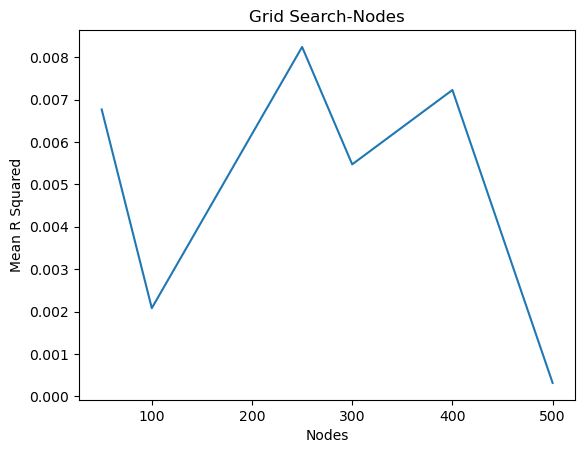

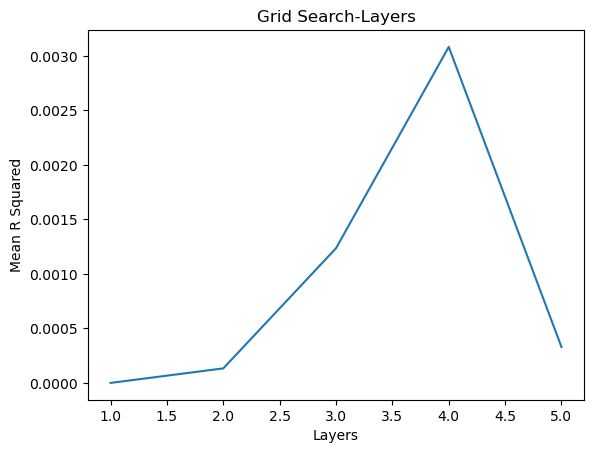

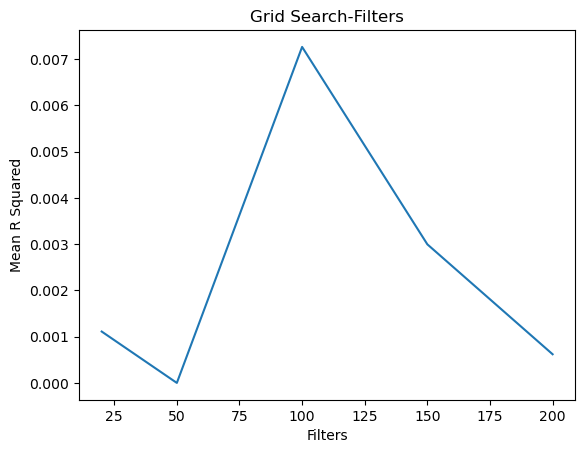

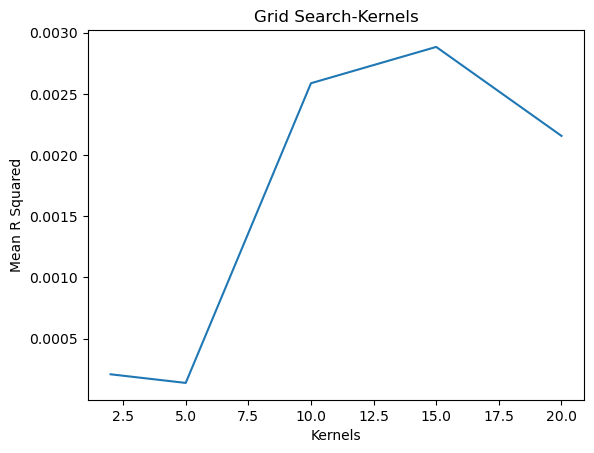

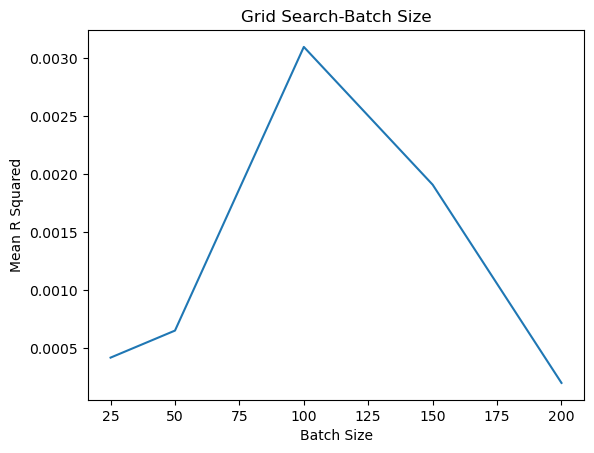

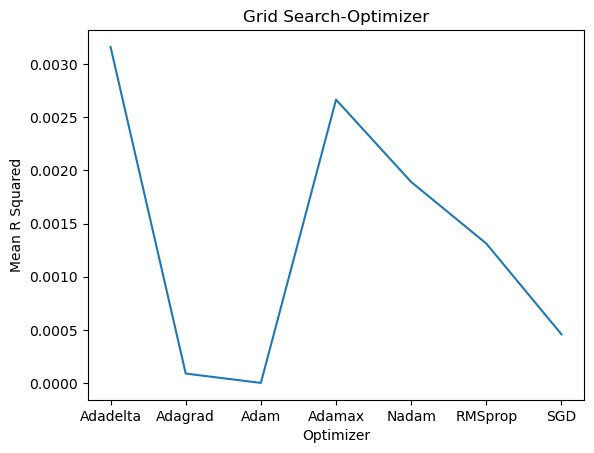

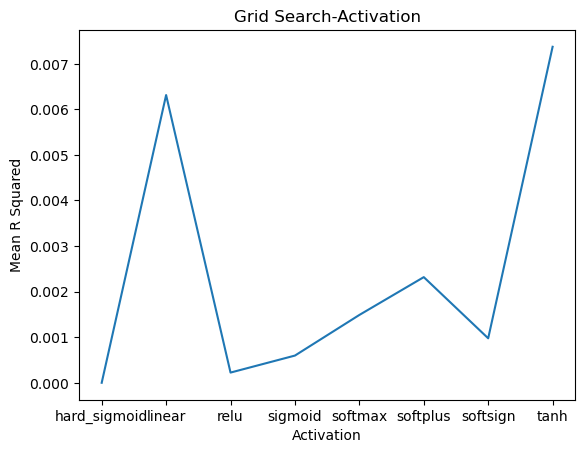

In [42]:
#create new data frame that gives mean r squared and plot
f1= plt.figure()
f2= plt.figure()
f3= plt.figure()
f4= plt.figure() 
f5= plt.figure()
f6= plt.figure()
f7= plt.figure()


print(GS_Nodes)
for i in Nodes_Results:
    print(i)
    
GS_Nodes_Grouped=(GS_Nodes.groupby(['Nodes']).mean())
print(GS_Nodes_Grouped)

# plot results
ax1 = f1.add_subplot(111)
ax1.plot(GS_Nodes_Grouped)
ax1.set_xlabel("Nodes")
ax1.set_ylabel("Mean R Squared")
ax1.set_title ("Grid Search-Nodes")




print(GS_Layers)
for i in Layers_Results:
    print(i)
    
GS_Layers_Grouped=(GS_Layers.groupby(['Layers']).mean())
print(GS_Layers_Grouped)

# plot results
ax2 = f2.add_subplot(111)
ax2.plot(GS_Layers_Grouped)
ax2.set_xlabel("Layers")
ax2.set_ylabel("Mean R Squared")
ax2.set_title ("Grid Search-Layers")

print(GS_Filters)
for i in Filters_Results:
    print(i)
    
GS_Filters_Grouped=(GS_Filters.groupby(['Filters']).mean())
print(GS_Filters_Grouped)

# plot results

ax3 = f3.add_subplot(111)
ax3.plot(GS_Filters_Grouped)
ax3.set_xlabel("Filters")
ax3.set_ylabel("Mean R Squared")
ax3.set_title ("Grid Search-Filters")



print(GS_Kernels)
for i in Kernels_Results:
    print(i)
    
GS_Kernels_Grouped=(GS_Kernels.groupby(['Kernels']).mean())
print(GS_Kernels_Grouped)

# plot results
ax4 = f4.add_subplot(111)
ax4.plot(GS_Kernels_Grouped)
ax4.set_xlabel("Kernels")
ax4.set_ylabel("Mean R Squared")
ax4.set_title ("Grid Search-Kernels")


print(GS_Batch_Sizes)
for i in Batch_Sizes_Results:
    print(i)
    
GS_Batch_Sizes_Grouped=(GS_Batch_Sizes.groupby(['Batch Sizes']).mean())
print(GS_Batch_Sizes_Grouped)

# plot results
ax5 = f5.add_subplot(111)
ax5.plot(GS_Batch_Sizes_Grouped)
ax5.set_xlabel("Batch Size")
ax5.set_ylabel("Mean R Squared")
ax5.set_title ("Grid Search-Batch Size")


print(GS_Optimizer)
for i in Optimizer_Results:
    print(i)
    
GS_Optimizer_Grouped=(GS_Optimizer.groupby(['Optimizer']).mean())
print(GS_Optimizer_Grouped)

# plot results
ax6 = f6.add_subplot(111)
ax6.plot(GS_Optimizer_Grouped)
ax6.set_xlabel("Optimizer")
ax6.set_ylabel("Mean R Squared")
ax6.set_title ("Grid Search-Optimizer")


print(GS_Activation)
for i in Activation_Results:
    print(i)
    
GS_Activation_Grouped=(GS_Activation.groupby(['Activation']).mean())
print(GS_Activation_Grouped)

# plot results
ax7 = f7.add_subplot(111)
ax7.plot(GS_Activation_Grouped)
ax7.set_xlabel("Activation")
ax7.set_ylabel("Mean R Squared")
ax7.set_title ("Grid Search-Activation")



In [147]:
#for grid search of multiple parameters
#Make a table of all the variations and output r squared
Grid_Search=pd.DataFrame()
row=0
Grid_Search["Nodes"]=""
Grid_Search["Layers"]=""
Grid_Search["Filters"]=""
Grid_Search["Kernels"]=""
Grid_Search["Batch_Sizes"]=""
Grid_Search["Optimizer"]=""
Grid_Search["Activation"]=""
for i in nodes:
    for j in layers:
        for k in nbr_filters:
            for l in filter_len:
                for m in batch_size:
                    for n in optimizer:
                        for o in activation:
                                Grid_Search.loc[row]=(i,j,k,l,m,n, o)
                                row+=1
print(Grid_Search.head())
yield

for i in nodes:
    for j in layers:
            for k in nbr_filters:
                for l in filter_len:
                    for m in batch_size:
                        for n in optimizer:
                            for o in activation:
                                model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                                            inp_len=133, nodes=i, layers=j, nbr_filters=k, filter_len=l, dropout1=0,
                                           dropout2=0,dropout3=0.2, batch_size=m, optimizer=n, activation=o)
                        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
                        r = r2(e_test['Count Freq'], e_test['pred'])
                        e_test['pred']
                        R_Squared.append(r)
                        a= "When there are", i,"nodes", j, "layers", k, "filters", l, "kernels", m, "batch size", n, "optimizer, and", o, "activation,  the r squared value is", r
                        Results.append(a)
                        
Grid_Search["R Squared"]=R_Squared

print(Grid_Search)

   Nodes  Layers  Epochs  Filters  Kernels  Batch_Sizes Optimizer Activation
0     50       1       3       20        2           50       SGD    softmax
1     50       1       3       20        2           50       SGD   softplus
2     50       1       3       20        2           50       SGD   softsign
3     50       1       3       20        2           50       SGD       relu
4     50       1       3       20        2           50       SGD       tanh


SyntaxError: 'yield' outside function (2445889806.py, line 23)